In [72]:
import numpy as np
from mpmath import mp
from mpmath import besseli

def get_initial_coefficients(J, n_max=50):
    """
    Calculate initial Fourier coefficients for XY model using modified Bessel functions
    
    Args:
        J (float): Coupling constant (J/kT)
        n_max (int): Maximum n value for truncation
        
    Returns:
        Array of coefficients λ_n from -n_max to n_max
    """
    # Initialize with high precision
    mp.dps = 50  # Set precision
    
    # Create array from -n_max to n_max
    lambda_n = np.zeros(2*n_max + 1, dtype='object')
    
    for idx, n in enumerate(range(-n_max, n_max + 1)):
        lambda_n[idx] = mp.besseli(abs(n), J)
    
    # Normalize
    lambda_n = lambda_n / max(abs(x) for x in lambda_n)
    
    return lambda_n

def bond_moving(lambda_A, lambda_B):
    """
    Perform bond-moving step combining two different interactions
    
    Args:
        lambda_A: First series of Fourier coefficients (-n_max to n_max)
        lambda_B: Second series of Fourier coefficients (-n_max to n_max)
        
    Returns:
        Bond-moved coefficients
    """
    n_max = (len(lambda_A) - 1) // 2
    lambda_tilde = np.zeros(2*n_max + 1, dtype='object')
    
    for k in range(-n_max, n_max + 1):
        k_idx = k + n_max
        sum_terms = mp.mpf('0')
        for n in range(-n_max, n_max + 1):
            n_idx = n + n_max
            m = k - n
            if abs(m) <= n_max:
                m_idx = m + n_max
                sum_terms += lambda_A[n_idx] * lambda_B[m_idx]
        lambda_tilde[k_idx] = sum_terms
    
    # Normalize
    lambda_tilde = lambda_tilde / max(abs(x) for x in lambda_tilde)
    
    return lambda_tilde

def decimation(lambda_12, lambda_23):
    """
    Perform decimation step by integrating over middle spin
    
    Args:
        lambda_12: Fourier coefficients of first interaction (-n_max to n_max)
        lambda_23: Fourier coefficients of second interaction (-n_max to n_max)
        
    Returns:
        Decimated coefficients
    """
    n_max = (len(lambda_12) - 1) // 2
    lambda_prime = np.zeros(2*n_max + 1, dtype='object')
    
    for n in range(-n_max, n_max + 1):
        n_idx = n + n_max
        lambda_prime[n_idx] = lambda_12[n_idx] * lambda_23[n_idx]
    
    # Normalize
    lambda_prime = lambda_prime / max(abs(x) for x in lambda_prime)
    
    return lambda_prime

def rg_step(lambda_l, b=2, d=2):
    """
    Perform one complete RG step: bond-moving followed by decimation
    
    Args:
        lambda_l: Input coefficients
        b: Length rescaling factor
        d: Dimension
        
    Returns:
        Renormalized coefficients
    """
    # Calculate number of bonds to combine in bond-moving
    m = b**(d-1)
    
    # Bond moving
    lambda_tilde = lambda_l
    for _ in range(m-1):
        lambda_tilde = bond_moving(lambda_tilde, lambda_l)
        
    # Decimation
    lambda_prime = decimation(lambda_tilde, lambda_tilde)
    
    return lambda_prime

In [74]:
# Example usage
J = 1
n_max = 5
lambda_l = get_initial_coefficients(J, n_max)
mp.nprint(lambda_l, 3)

[mpf('0.00021441471626972079058040303770008774768836197723504768')
 mpf('0.0021619097940676053298194692120104925298237455782819212')
 mpf('0.017509693068810563429136156733784027986278326603490392')
 mpf('0.10722006820693098590463640961471466044749370519922438')
 mpf('0.4463899658965345070476817951926426697762531474003879') mpf('1.0')
 mpf('0.4463899658965345070476817951926426697762531474003879')
 mpf('0.10722006820693098590463640961471466044749370519922438')
 mpf('0.017509693068810563429136156733784027986278326603490392')
 mpf('0.0021619097940676053298194692120104925298237455782819212')
 mpf('0.00021441471626972079058040303770008774768836197723504768')]


In [15]:
# Example usage
J = 1
n_max = 10
lambda_l = get_initial_coefficients(J, n_max)

# Perform several RG steps
n_steps = 10
for _ in range(n_steps):
    lambda_l = rg_step(lambda_l)
lambda_l

array([mpf('1.7350560566446500841953350624125824511143453628887892e-31'),
       mpf('1.7316786921885663554068998382762064554132891712304681e-28'),
       mpf('1.2128887810294382040689560744443326338101901137000503e-25'),
       mpf('5.9617545806426890021503424130720146979386178950569967e-23'),
       mpf('2.0564884126667082868810737693703636998661267147831788e-20'),
       mpf('4.9782548769186768667908141236688507805957644475539045e-18'),
       mpf('0.00000000000000084571947267827235929720806785402526762491308506733614'),
       mpf('0.00000000000010082623484619637719034342650006619822173013942101017'),
       mpf('0.0000000000084356486659199874268295550064967992118998290902638827'),
       mpf('0.00000000049529147453022370775403930926592449974123597486093627'),
       mpf('0.000000020407997806225251615806308291751239447978294614360028'),
       mpf('0.00000059011531764994730242149681103639854615837043544409073'),
       mpf('0.00001197485067454707239320727717481357560179555119681622

In [17]:
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def track_rg_flow(J, n_max=20, n_steps=20):
    """
    Track RG flow by storing coefficients at each step
    
    Args:
        J: Initial coupling
        n_max: Maximum Fourier mode
        n_steps: Number of RG steps
        
    Returns:
        flow_history: Array of shape (n_steps+1, 2*n_max+1) containing coefficients
    """
    # Initialize with high precision
    mp.dps = 50
    
    # Convert to float array for visualization
    flow_history = np.zeros((n_steps+1, 2*n_max+1))
    
    # Get initial coefficients
    lambda_l = get_initial_coefficients(J, n_max)
    flow_history[0] = np.array([float(x) for x in lambda_l])
    
    # Perform RG steps
    for i in range(n_steps):
        lambda_l = rg_step(lambda_l)
        flow_history[i+1] = np.array([float(x) for x in lambda_l])
        
    return flow_history

def plot_rg_flow(flow_history, J):
    """
    Create visualizations of the RG flow
    
    Args:
        flow_history: Array of coefficients at each RG step
        J: Initial coupling value used (for title)
    """
    n_steps, n_coeffs = flow_history.shape
    n_max = (n_coeffs - 1) // 2
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Heatmap of coefficient evolution
    ax1 = plt.subplot(221)
    im = ax1.imshow(flow_history.T, 
                    aspect='auto',
                    extent=[-0.5, n_steps-0.5, -n_max-0.5, n_max+0.5],
                    norm=LogNorm(vmin=max(1e-10, flow_history.min())), 
                    cmap='viridis')
    plt.colorbar(im, ax=ax1)
    ax1.set_xlabel('RG Step')
    ax1.set_ylabel('Fourier Mode n')
    ax1.set_title('Evolution of Fourier Coefficients')
    
    # 2. Line plot of selected coefficients over RG steps
    ax2 = plt.subplot(222)
    selected_modes = [0, 1, 2, 4, 8]  # Modes to highlight
    for n in selected_modes:
        if n <= n_max:
            n_idx = n + n_max
            ax2.plot(range(n_steps), flow_history[:, n_idx], 
                    label=f'n={n}', marker='o', markersize=3)
    ax2.set_xlabel('RG Step')
    ax2.set_ylabel('Coefficient Value')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.set_title('Evolution of Selected Modes')
    
    # 3. Initial coefficient distribution
    ax3 = plt.subplot(223)
    n_range = np.arange(-n_max, n_max+1)
    ax3.plot(n_range, flow_history[0], 'o-')
    ax3.set_xlabel('Fourier Mode n')
    ax3.set_ylabel('Coefficient Value')
    ax3.set_title('Initial Coefficient Distribution')
    
    # 4. Final coefficient distribution
    ax4 = plt.subplot(224)
    ax4.plot(n_range, flow_history[-1], 'o-')
    ax4.set_xlabel('Fourier Mode n')
    ax4.set_ylabel('Coefficient Value')
    ax4.set_title('Final Coefficient Distribution')
    
    plt.suptitle(f'RG Flow Analysis for XY Model (J={J})')
    plt.tight_layout()
    
    return fig

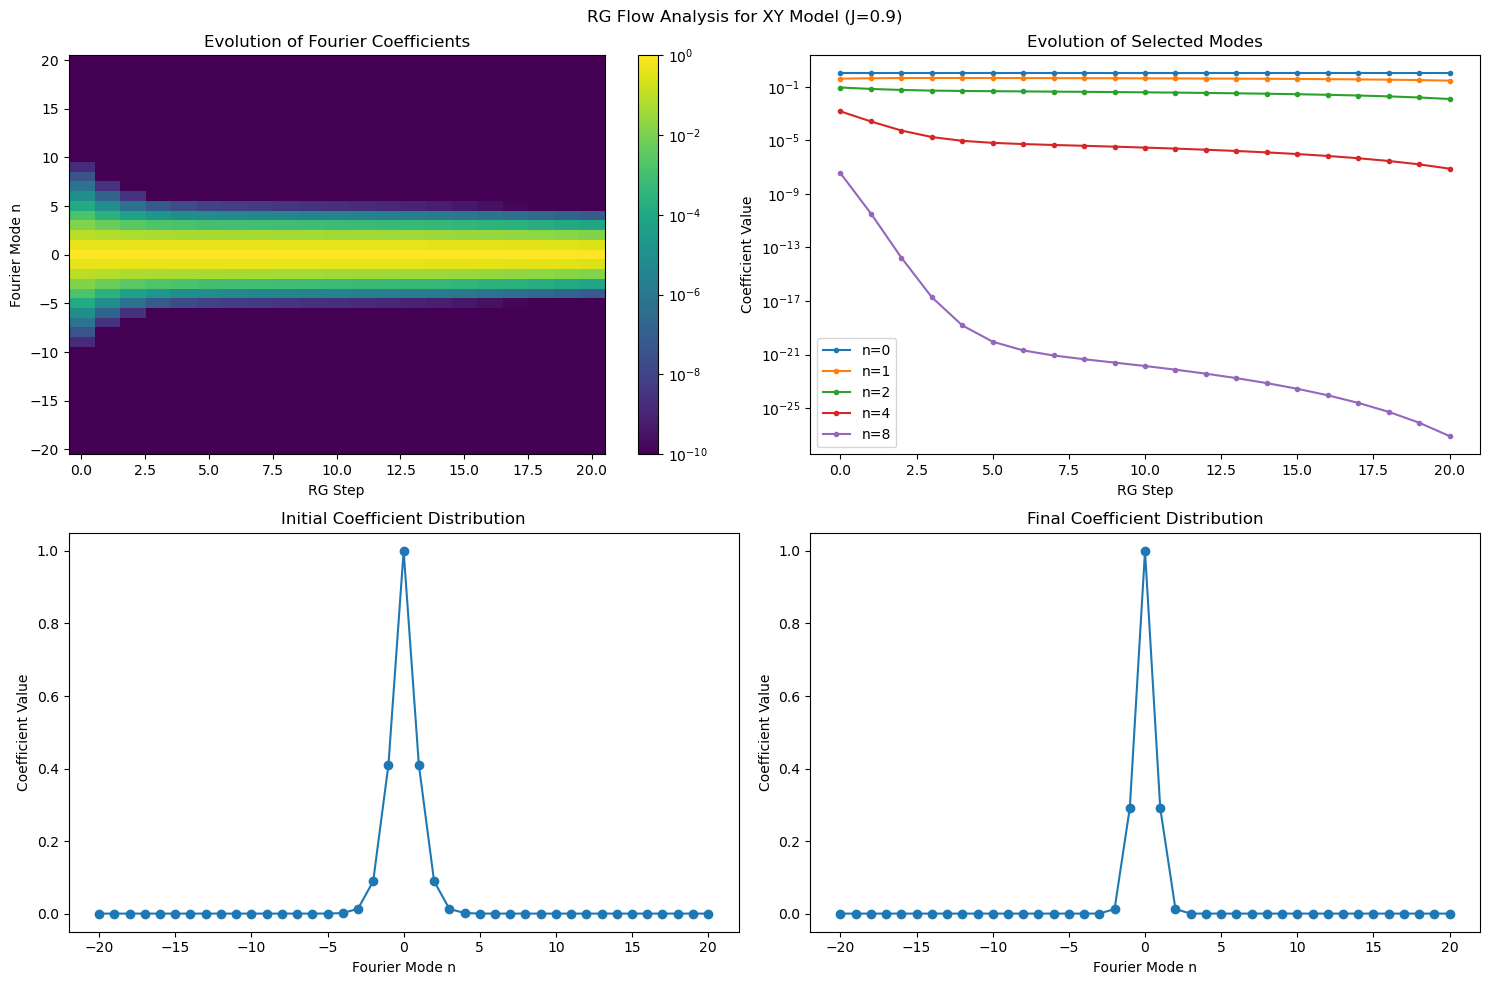

In [33]:
n_max = 20
n_steps = 20
    
J = .9
flow_history = track_rg_flow(J, n_max, n_steps)
fig = plot_rg_flow(flow_history, J)
plt.show()

In [35]:
def reconstruct_potential(lambda_n):
    """
    Reconstruct potential u(θ) from Fourier coefficients
    
    Args:
        lambda_n: Array of Fourier coefficients from -n_max to n_max
        
    Returns:
        theta: Array of angles
        u: Potential values at those angles
    """
    n_max = (len(lambda_n) - 1) // 2
    
    # Create fine grid of angles
    theta = np.linspace(0, 2*np.pi, 1000)
    
    # Initialize potential
    u = np.zeros_like(theta, dtype='complex')
    
    # Sum over all modes
    for n in range(-n_max, n_max + 1):
        n_idx = n + n_max
        u += lambda_n[n_idx] * np.exp(1j * n * theta)
    
    # Potential should be real
    u = np.real(u)
    
    return theta, u

def plot_potential_evolution(flow_history, J, steps_to_show=None):
    """
    Visualize the evolution of the potential u(θ)
    
    Args:
        flow_history: Array of coefficients at each RG step
        J: Initial coupling value
        steps_to_show: List of RG steps to show (default: [0, 1, 5, -1])
    """
    if steps_to_show is None:
        steps_to_show = [0, 1, 5, -1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Regular plot
    for step in steps_to_show:
        theta, u = reconstruct_potential(flow_history[step])
        label = f'Step {step}' if step != -1 else f'Step {len(flow_history)-1}'
        ax1.plot(theta, u, label=label)
    
    ax1.set_xlabel('θ')
    ax1.set_ylabel('u(θ)')
    ax1.set_title(f'Potential Evolution (J={J})')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Polar plot
    ax2 = plt.subplot(122, projection='polar')
    for step in steps_to_show:
        theta, u = reconstruct_potential(flow_history[step])
        # Shift potential to be positive for visualization
        u = u - u.min() + 0.1
        label = f'Step {step}' if step != -1 else f'Step {len(flow_history)-1}'
        ax2.plot(theta, u, label=label)
    
    ax2.set_title('Polar View of Potential')
    ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
    
    plt.tight_layout()
    return fig

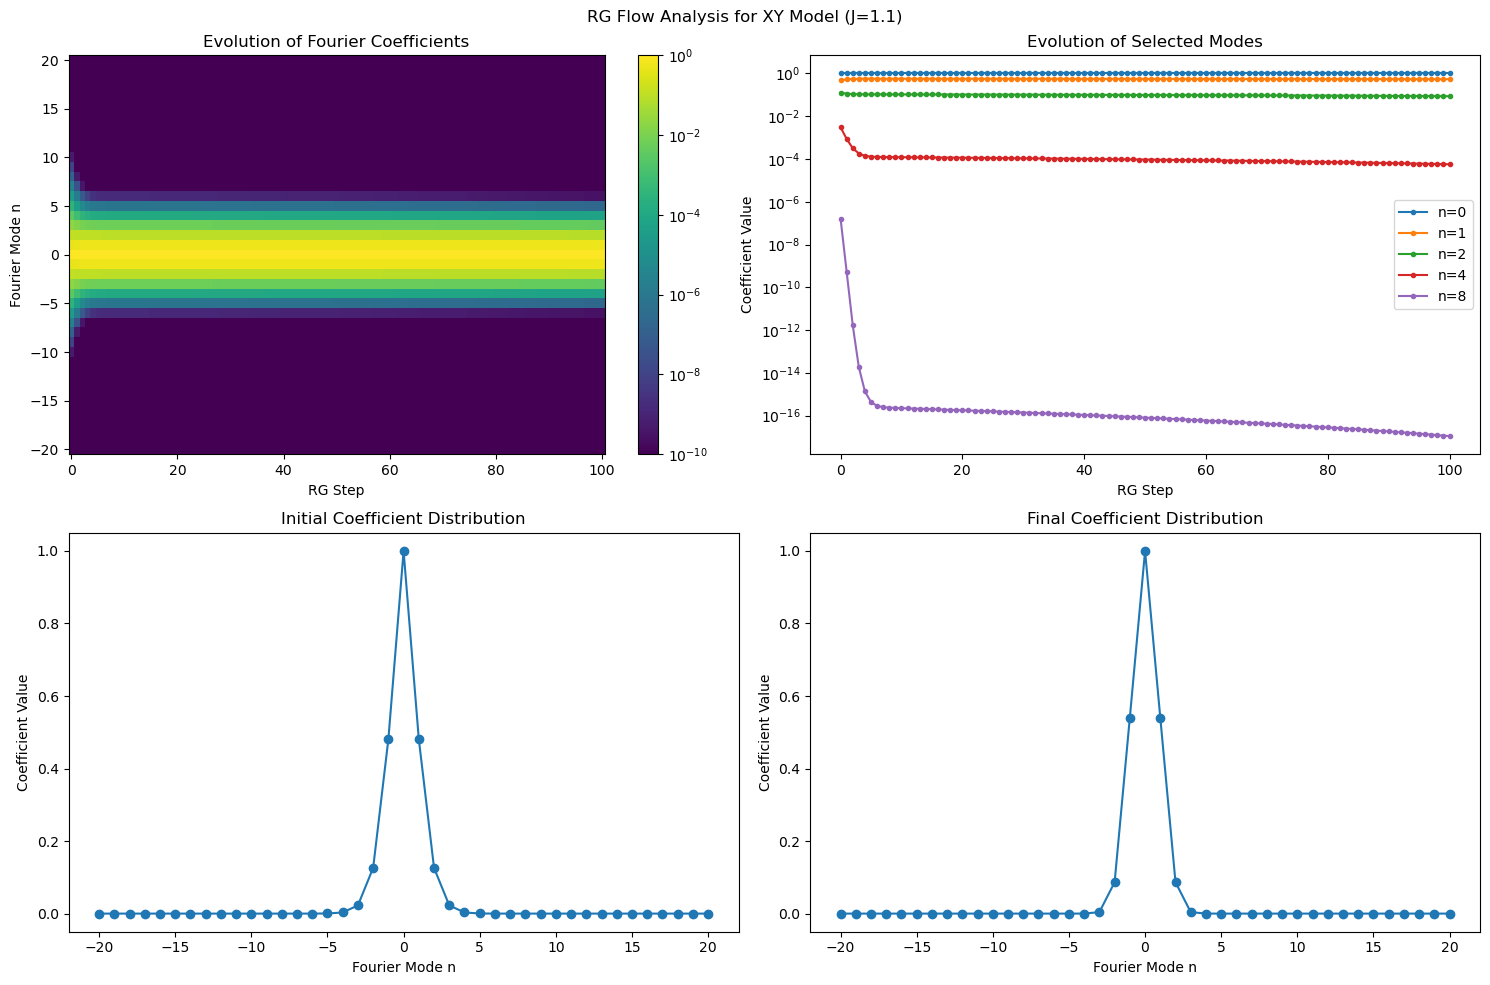

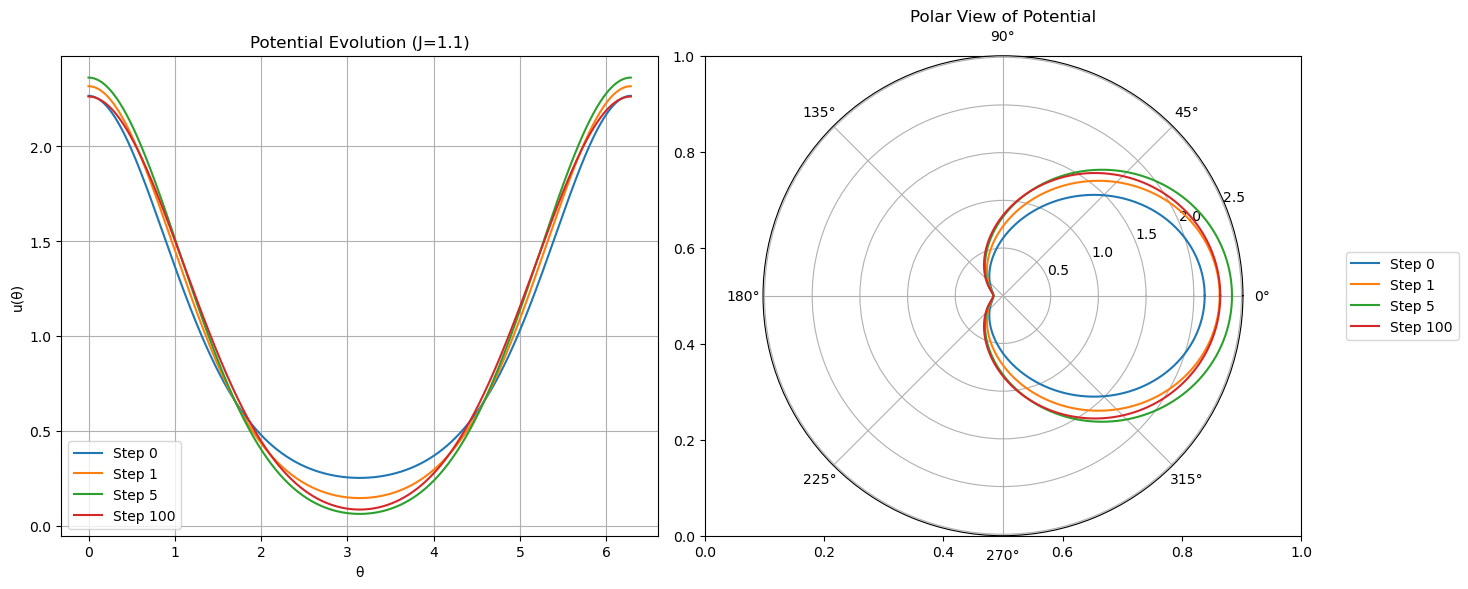

In [45]:
J = 1.1
n_max = 20
n_steps = 100

# Track RG flow
flow_history = track_rg_flow(J, n_max, n_steps)

# Plot coefficients evolution
fig1 = plot_rg_flow(flow_history, J)
plt.show()

# Plot potential evolution
fig2 = plot_potential_evolution(flow_history, J)
plt.show()